# Local Model Training

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from model import get_dataloaders

import matplotlib.pyplot as plt

from model import FederatedCNN


100%|██████████| 10/10 [01:01<00:00,  6.20s/it]


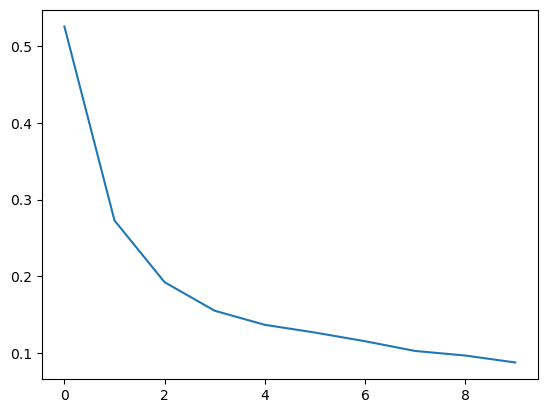

In [46]:
SRC_PATH = "./resources/pneumoniamnist.npz"


model = FederatedCNN(in_channels=1, num_classes=1)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.BCEWithLogitsLoss()

train_dl, val_dl, test_dl = get_dataloaders(SRC_PATH)

local_train_metrics, local_val_metrics = model.train_model(
    epochs=10,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=val_dl
)

local_test_metrics = model.test_epoch(
    criterion=ce_loss,
    test_loader=test_dl
)

plt.plot(local_train_metrics["loss"])


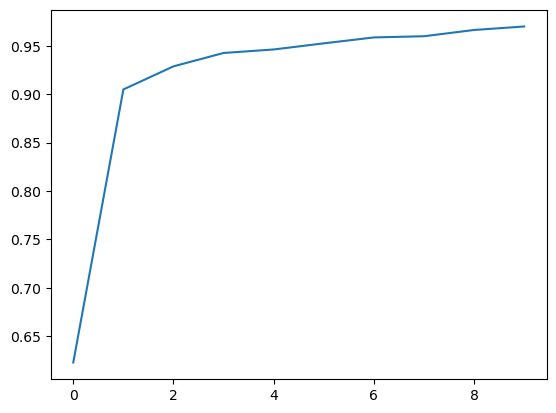

In [47]:
plt.plot(local_train_metrics["acc"])

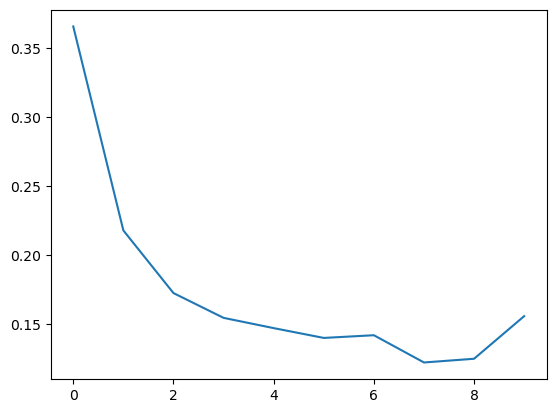

In [48]:
plt.plot(local_val_metrics["loss"])

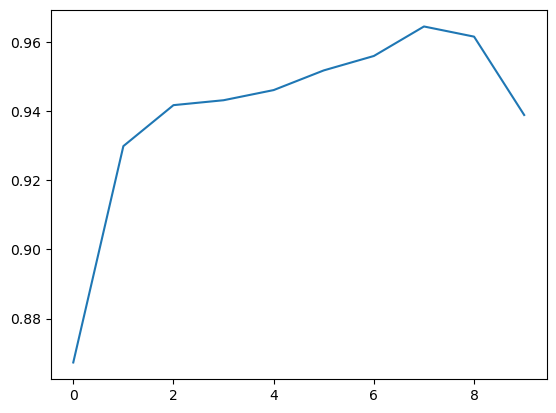

In [49]:
plt.plot(local_val_metrics["acc"])

# Split Data for Federated Learning

In [38]:
import numpy as np
from model.dataset import read_medmnist

SRC_PATH = "./resources/pneumoniamnist.npz"
CLIENTS = 4  # Number of federated clients

data, labels = read_medmnist(SRC_PATH)
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")


Shape of data: (5856, 28, 28) and shape of labels: (5856, 1)


In [39]:
l_data, l_labels = np.split(data, CLIENTS), np.split(labels, CLIENTS)
for client in range(CLIENTS):
    np.savez(f"./resources/pneumoniamnist_client{client}.npz", images=l_data[client], labels=l_labels[client])
    print("saved client data for client", client)

saved client data for client 0
saved client data for client 1
saved client data for client 2
saved client data for client 3


In [40]:
data, labels = read_medmnist("./resources/pneumoniamnist_client0.npz")
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")

Shape of data: (1464, 28, 28) and shape of labels: (1464, 1)


# Analyze federated model

In [41]:
from collections import defaultdict
import torch
import os
import re
import zipfile
from pathlib import Path

test_no = 2
client_no = [0, 1, 2, 3]



def get_metrics(metrics):
    return {
        "loss": [eval(m)["loss"] for m in metrics],
        "acc": [eval(m)["acc"] for m in metrics]
    }


final_model = None
test_metrics = []
val_metrics = []

# iterate over all files in the directory
result_files = []
path = os.path.abspath("./data/tests")
for file in os.listdir(path):
    if re.search(f"results_test_{test_no}_client_{client_no}_fc_bkim_[0-9]+\.zip", file):
        fp = Path(os.path.join(path, file))
        rp = path + "\\" + fp.stem  # result path
        with zipfile.ZipFile(fp, 'r') as zip_ref:
            zip_ref.extractall(rp)
        for rf in os.listdir(rp):
            if rf == "model.pt":
                final_model = torch.load(os.path.join(rp, rf))
            if rf == "test_metrics.txt":
                with open(os.path.join(rp, rf), "r") as f:
                    test_metrics.append(get_metrics(f.readlines()))
            if rf == "val_metrics.txt":
                with open(os.path.join(rp, rf), "r") as f:
                    val_metrics.append(get_metrics(f.readlines()))


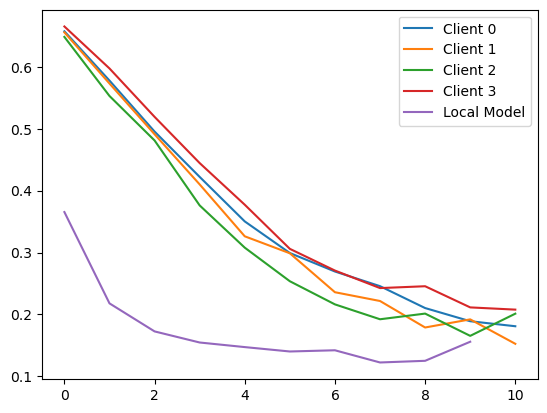

In [52]:
import matplotlib.pyplot as plt

for i in range(len(val_metrics)):
    plt.plot(val_metrics[i]["loss"], label=f"Client {i}")

plt.plot(local_val_metrics["loss"], label="Local Model")
plt.legend()

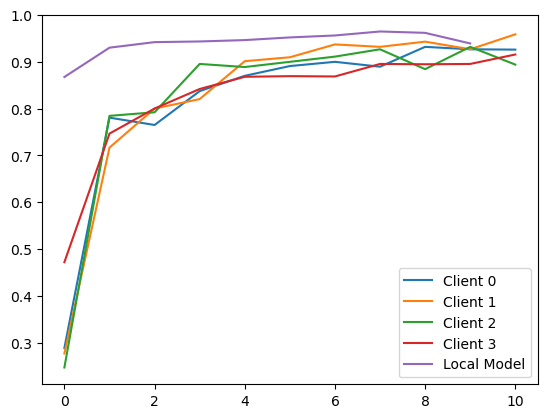

In [53]:
for i in range(len(val_metrics)):
    plt.plot(val_metrics[i]["acc"], label=f"Client {i}")

plt.plot(local_val_metrics["acc"], label="Local Model")
plt.legend()

In [61]:
avg_test_metrics = defaultdict(list)
for i in range(len(test_metrics)):
    for k, v in test_metrics[i].items():
        avg_test_metrics[k].append(v[0])

for k, v in avg_test_metrics.items():
    print(f"Average test {k}:", np.mean(v))

print("=====================================")
for k, v in local_test_metrics.items():
    print(f"Local test {k}:", np.mean(v))

Average test loss: 0.1791728570436438
Average test acc: 0.9332465256253878
Local test loss: 0.133537294381919
Local test acc: 0.9654166673620542
